In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee

/Users/nasserm/Documents/vscode/lsstda/bayesian-fpl/fpl_functions.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.rename(columns={player_opponent_team_id_col: 'opponent_team', player_total_points_col: 'total_points'}, inplace=True)
/Users/nasserm/Documents/vscode/lsstda/bayesian-fpl/fpl_functions.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['fixture'] = self.data['opponent_team'].map(teams_df.set_index(team_id_col)[team_strength_col])
/Users/nasserm/Documents/vscode/lsstda/bayesian-fpl/fpl_functions.py:47: SettingWithCopyWarning: 


Running MCMC...


100%|██████████| 5000/5000 [00:17<00:00, 278.47it/s]


MCMC run complete.
Gelman-Rubin diagnostic (R-hat values):
alpha: 1.0006
beta_form: 1.0005
beta_fixture: 1.0006
sigma: 1.0008

Plotting MCMC chains...


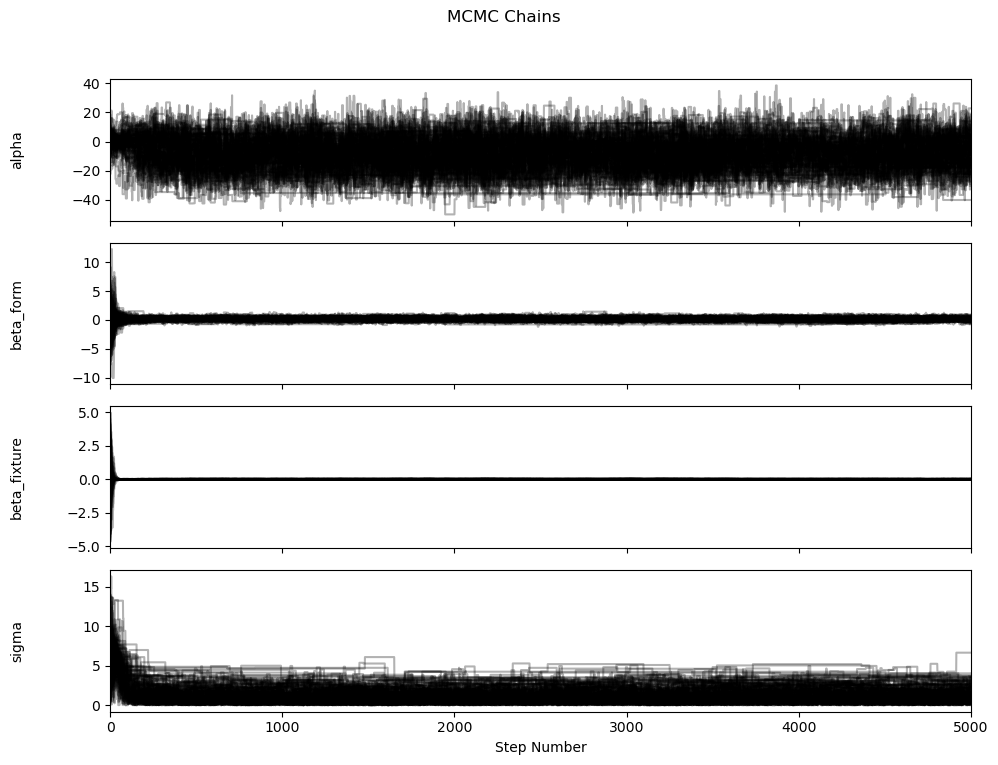


Plotting corner plot...


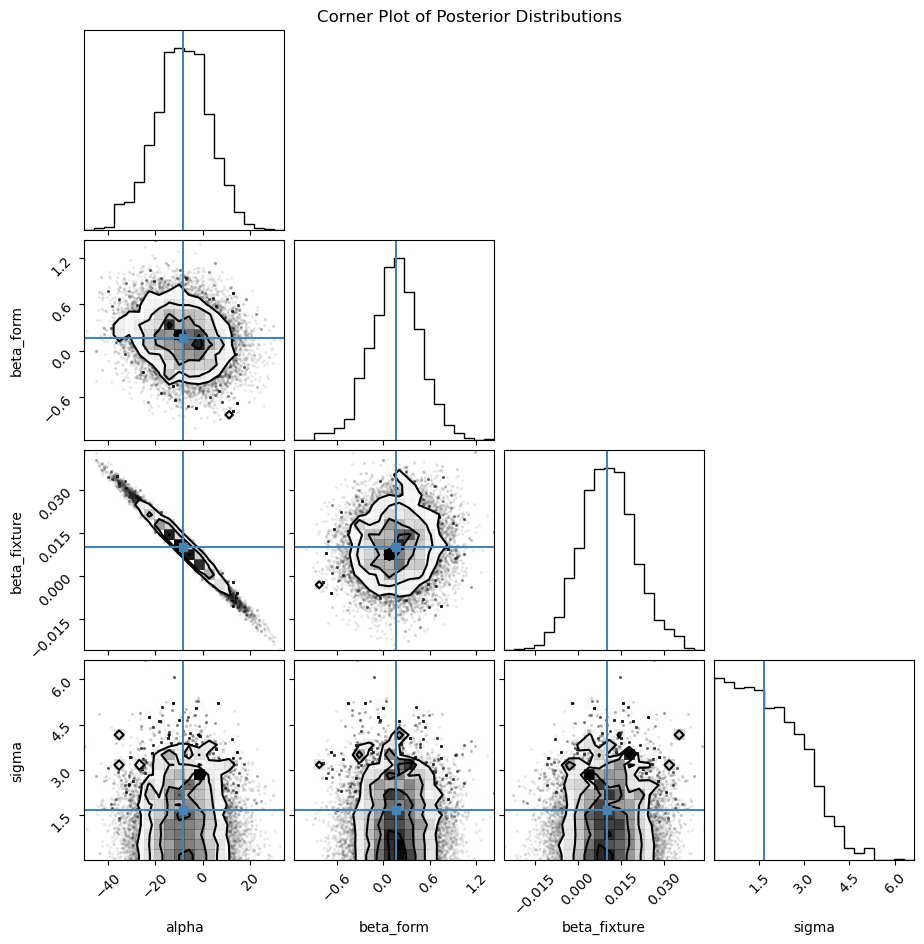


Predicting points for next fixture (strength 1100)...
Predicted points for next game (fixture strength 1100):
Mean: 3.01, Std: 1.63

Plotting prediction histogram...


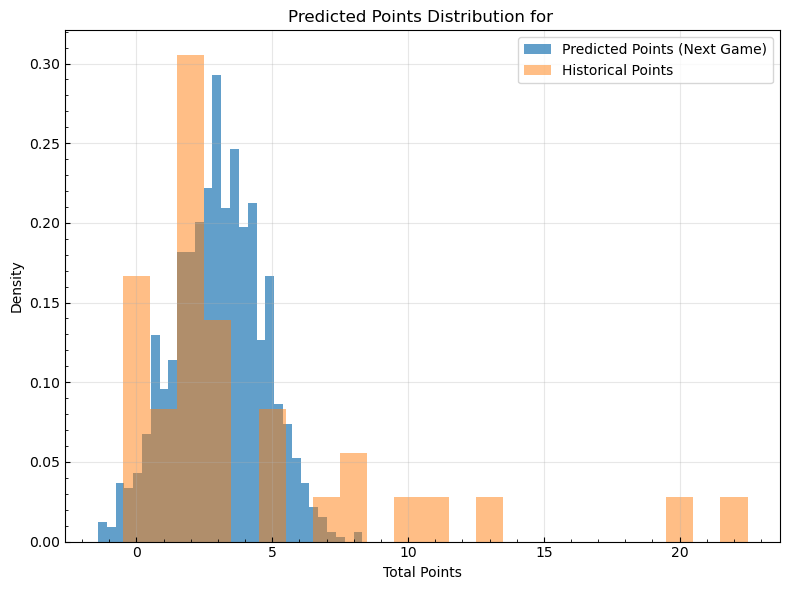

In [199]:
from fpl_functions import player

# --- Example using the player class ---


player = player(gw_data_path='/Users/nasserm/Documents/vscode/lsstda/bayesian-fpl/Fantasy-Premier-League/data/2024-25/players/Justin_Kluivert_71/gw.csv', teams_data_path='teams.csv')

print("\nRunning MCMC...")
player.run_mcmc(n_steps=5000, n_burnin=1000, progress=True) # Using parameters from your notebook

# 3. Plot the MCMC chains
print("\nPlotting MCMC chains...")
player.plot_chains()

# 4. Plot the corner plot
print("\nPlotting corner plot...")
player.plot_corner()

next_fixture_strength_example = 1100
print(f"\nPredicting points for next fixture (strength {next_fixture_strength_example})...")
mean_pts, std_pts, predicted_samples = player.predict_points(next_fixture_strength=next_fixture_strength_example, n_draws=1000)

if predicted_samples is not None:
    # 6. Plot the prediction histogram
    print("\nPlotting prediction histogram...")
    player.plot_prediction_histogram(predicted_samples, player_name="")

    # You can save these predicted points if needed
    # np.savetxt('predicted_points_haaland_class.csv', predicted_samples, delimiter=',')
    # print(f"\nPredicted points saved to 'predicted_points_haaland_class.csv'")

In [152]:
df = pd.read_csv('gw.csv')
mo = df[['opponent_team', 'total_points']]
mo.head()

,opponent_team,total_points
0,10,14
1,4,10
2,14,17
3,16,2
4,3,6


In [153]:
teams_df = pd.read_csv('teams.csv')
teams_df.head()

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,NaN,1,0,Arsenal,0,0,2,ARS,...,NaN,False,0,1350,1350,1390,1400,1310,1300,1
1,7,0,NaN,2,0,Aston Villa,0,0,6,AVL,...,NaN,False,0,1145,1240,1130,1180,1160,1300,2
2,91,0,NaN,3,0,Bournemouth,0,0,10,BOU,...,NaN,False,0,1170,1200,1120,1180,1220,1220,127
3,94,0,NaN,4,0,Brentford,0,0,8,BRE,...,NaN,False,0,1130,1180,1100,1100,1160,1260,130
4,36,0,NaN,5,0,Brighton,0,0,9,BHA,...,NaN,False,0,1140,1165,1090,1140,1190,1190,131


In [154]:
mo['fixture'] = mo['opponent_team'].map(teams_df.set_index('id')['strength_defence_home'])

/var/folders/cp/8z3h6wl95fn4l6kxwr2y_0hm0000gn/T/ipykernel_59109/102581732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mo['fixture'] = mo['opponent_team'].map(teams_df.set_index('id')['strength_defence_home'])


In [155]:
form = []
for i in range(0, len(mo)):
    if i==0:
        form.append(0)
    elif i == 1:
        form.append(mo['total_points'].iloc[i])
    elif i == 2:
        form.append(np.mean(mo['total_points'].iloc[:i]))
    elif i == 3:
        form.append(np.mean(mo['total_points'].iloc[:i]))
    else:
        form.append(np.mean(mo['total_points'].iloc[i-4:i]))

In [156]:
mo['form'] = form

/var/folders/cp/8z3h6wl95fn4l6kxwr2y_0hm0000gn/T/ipykernel_59109/994197318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mo['form'] = form


In [157]:
from scipy.stats import norm
def get_model_predictions(theta, form, fixture):
    alpha, beta_1, beta_2, sigma = theta
    mu = alpha + beta_1*form + beta_2*fixture
    # Ensure sigma is positive to avoid domain errors
    sigma = np.abs(sigma)
    draw = norm.rvs(loc=mu, scale=sigma)
    return draw

In [158]:
def lnprior(theta):
    '''
    Calculate the log prior for the hierarchical model
    
    Parameters
    --------
    params : alpha, beta_1, beta_2, and sigma


    
    Returns
    --------
    lnp : float
        the log-prior for this set of parameters
    '''
    
    alpha, beta_1, beta_2, sigma = theta
    if -100<=alpha<=100 and -100<=beta_1<=100 and -100<=beta_2<=100 and 0 <= sigma <= 100:
        lnp = np.log(1/200) + np.log(1/200) + np.log(1/200) + np.log(1/100)
    else:
        lnp = -np.inf

    return lnp



In [159]:
def lnlikelihood(theta, observed_points, form, fixture, y_unc):
    y = observed_points
    model_preds = get_model_predictions(theta,form,fixture)
    lnl = -np.sum((y-model_preds)**2/(2*y_unc**2))
    
    return lnl

In [160]:
def lnprob(theta, observed_points, form, fixture, y_unc):
    return lnprior(theta) + lnlikelihood(theta, observed_points, form, fixture, y_unc)

In [161]:
ndim, nwalkers = 4, 100
alpha0 = np.random.rand(nwalkers, 1)
beta_1_0 = np.random.rand(nwalkers, 1)
beta_2_0 = np.random.rand(nwalkers, 1)
sigma0 = np.random.rand(nwalkers, 1) * mo['total_points'].std()
p0 = np.hstack([alpha0, beta_1_0, beta_2_0, sigma0])

In [162]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mo['total_points'], mo['form'], mo['fixture'], mo['total_points'].std()))
sampler.run_mcmc(p0, 5000, progress=True)

100%|██████████| 5000/5000 [02:58<00:00, 27.94it/s]


State([[ 9.49058202e+00  1.60510943e-02  2.92580929e-04  9.40417006e-01]
 [ 8.13319340e+00  2.46459881e-01 -8.10055663e-04  2.45922750e+00]
 [ 2.52825113e+01  2.01920597e-03 -1.34036009e-02  3.15390154e-01]
 [ 2.11938718e+01 -2.78664887e-01 -8.53604613e-03  3.98470194e+00]
 [ 2.12261135e+01 -1.07222319e-02 -1.06911364e-02  2.59798611e-02]
 [ 9.79008801e+00  1.03028487e-01 -9.99499604e-04  1.40878331e+00]
 [ 1.89858715e+01  2.15850411e-01 -1.07844400e-02  1.38044746e+00]
 [-1.16141749e+01  2.27394091e-01  1.58623189e-02  9.81382252e-01]
 [ 2.57062502e+01  1.68830037e-01 -1.41868270e-02  8.73453710e-01]
 [ 6.96900133e+00  7.07506658e-02  2.72250739e-03  4.13955811e-01]
 [ 2.41170068e+01 -3.40932154e-01 -1.00617912e-02  2.15308170e+00]
 [ 1.49132349e+01 -1.77349053e-01 -3.73780639e-03  2.73153235e+00]
 [ 1.68771138e+00  2.30689413e-01  3.38126684e-03  4.02503467e+00]
 [ 2.73927591e+01  5.06727461e-02 -1.57545548e-02  1.84438074e+00]
 [ 1.94062576e+01  1.92534724e-01 -9.26036591e-03  9.468

In [163]:
flat_samples = sampler.get_chain(discard=100, flat=True)
print("Gelman-Rubin diagnostic (R-hat values):")
for i, label in enumerate(labels):
    chains = sampler.get_chain(discard=100)[:, :, i]
    n_chains = chains.shape[1]
    n_samples = chains.shape[0]
    
    # Calculate between-chain variance
    chain_means = np.mean(chains, axis=0)
    overall_mean = np.mean(chain_means)
    B = n_samples * np.var(chain_means, ddof=1)
    
    # Calculate within-chain variance
    chain_vars = np.var(chains, axis=0, ddof=1)
    W = np.mean(chain_vars)
    
    # Calculate R-hat
    var_plus = ((n_samples - 1) / n_samples) * W + (1 / n_samples) * B
    r_hat = np.sqrt(var_plus / W)
    
    print(f"{label}: {r_hat:.4f}")

Gelman-Rubin diagnostic (R-hat values):
alpha: 1.0527
beta1: 1.0811
beta2: 1.0499
sigma: 1.1219


In [164]:
def plot_chains(ax, samples, i, labels):
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)


Text(0.5, 0, 'step number')

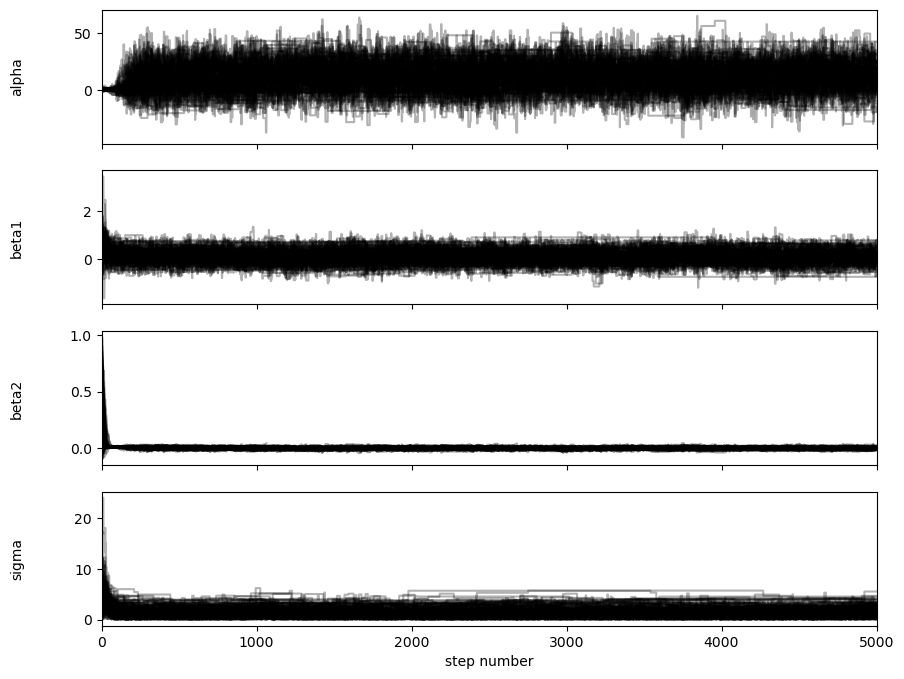

In [165]:
fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["alpha", "beta1", "beta2", "sigma"]
for i in range(ndim):
    plot_chains(axes[i], samples, i, labels)

axes[-1].set_xlabel("step number")

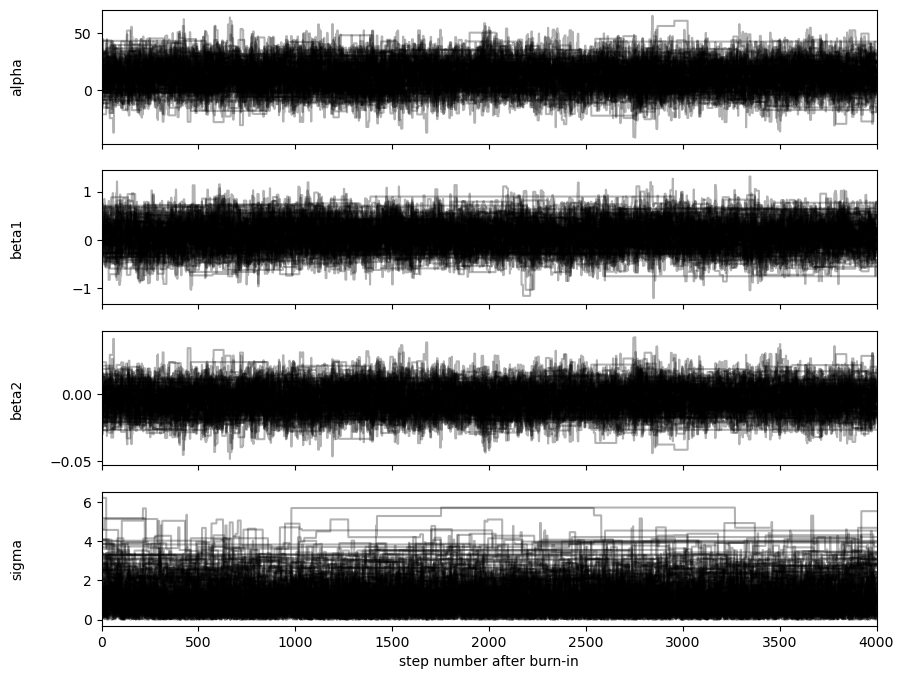

In [166]:
flat_samples = sampler.get_chain(discard=1000)

fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
labels = ["alpha", "beta1", "beta2", "sigma"]
for i in range(ndim):
    plot_chains(axes[i], flat_samples, i, labels)

axes[-1].set_xlabel("step number after burn-in");

/opt/anaconda3/envs/day5/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (4000) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


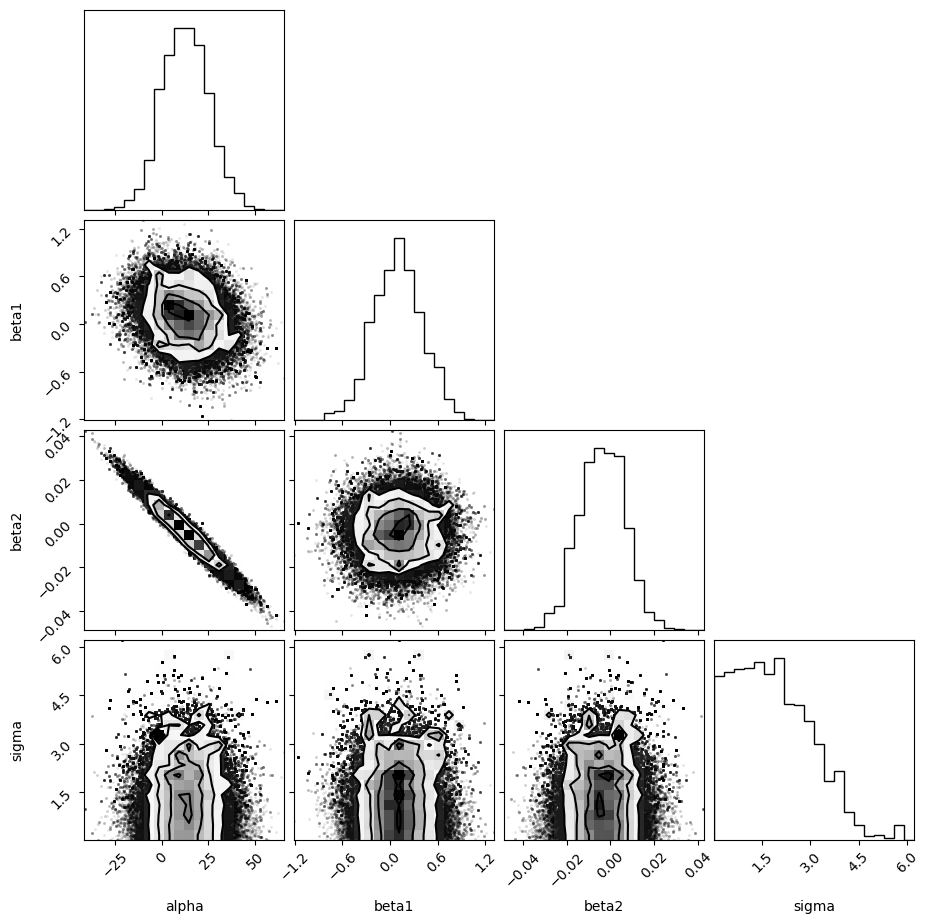

In [167]:
import corner

fig = corner.corner(flat_samples, labels=labels)

In [168]:
alpha = np.median(flat_samples[:,:, 0])
beta1 = np.median(flat_samples[:,:, 1])
beta2 = np.median(flat_samples[:,:, 2])
sigma = np.median(flat_samples[:,:, 3])

In [169]:
mo['form']

0      0.000000
1     10.000000
2     12.000000
3     13.666667
4     10.750000
5      8.750000
6      8.750000
7      5.250000
8      7.750000
9      8.750000
10     8.500000
11    11.250000
12    11.500000
13    12.250000
14    14.500000
15    12.250000
16    14.250000
17    13.250000
18    12.750000
19    13.250000
20     8.500000
21     7.000000
22     5.000000
23     7.250000
24    10.000000
25    11.250000
26    12.250000
27    11.750000
28    10.000000
29    11.750000
30     9.500000
31     6.500000
32     6.500000
33     3.500000
34     4.750000
35     4.750000
Name: form, dtype: float64

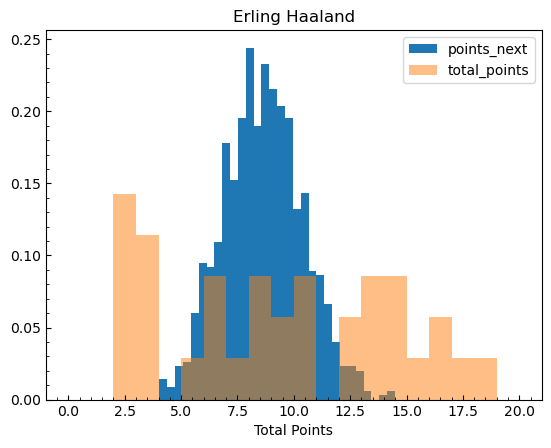

In [170]:
points_next = norm.rvs(loc=alpha + beta2 * 1160 + beta1 * mo['form'].iloc[-1], scale=sigma, size=1000)

fig, ax = plt.subplots()

ax.hist(points_next, bins=30, density=True, label='points_next')
ax.hist(mo['total_points'], bins=np.arange(0, 21), density=True, alpha=0.5, label='total_points')
ax.minorticks_on()
ax.tick_params(direction='in', which='both')
ax.legend()
ax.set_xlabel('Total Points')
ax.set_title('Erling Haaland')
plt.show()


In [171]:
np.savetxt('points_next_salah.csv', points_next, delimiter=',')
salah = points_next

In [175]:
merino = pd.read_csv('points_next_merino.csv')
haaland = pd.read_csv('points_next_halland.csv')

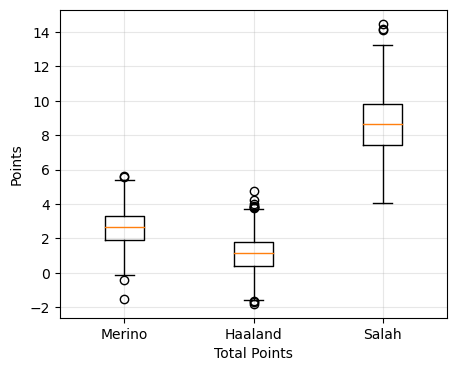

In [185]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.boxplot([merino.values.flatten(), haaland.values.flatten(), salah], labels=['Merino', 'Haaland', 'Salah'])
ax.set_ylabel('Points')
ax.set_title('Predicted Points Distribution - Box Plot Comparison')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Total Points')
ax.set_title('')
plt.show()

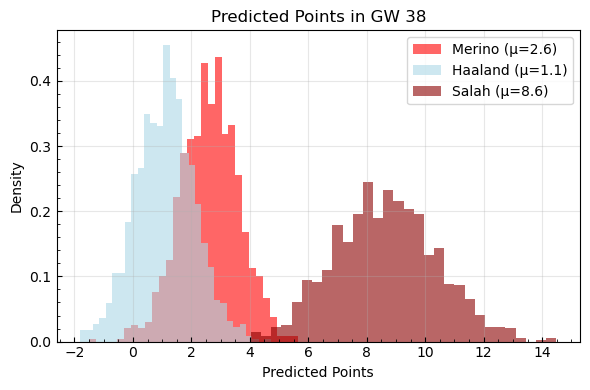

In [192]:
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histograms for each player
ax.hist(merino.values.flatten(), bins=30, alpha=0.6, density=True, label=f'Merino (μ={np.nanmean(merino):.1f})', color='red')
ax.hist(haaland.values.flatten(), bins=30, alpha=0.6, density=True, label=f'Haaland (μ={np.nanmean(haaland):.1f})', color='lightblue')
ax.hist(salah, bins=30, alpha=0.6, density=True, label=f'Salah (μ={np.nanmean(salah):.1f})', color='darkred')

# Add labels and formatting
ax.set_xlabel('Predicted Points')
ax.set_ylabel('Density')
ax.set_title('Predicted Points in GW 38')
ax.legend()
ax.grid(True, alpha=0.3, zorder=0)
ax.minorticks_on()
ax.tick_params(direction='in', which='both')

plt.tight_layout()
plt.show()

In [186]:
np.nanmean(haaland)

1.1088477296348949

2.6143560700078274

In [188]:
np.nanmean(salah)

8.649677735352832